### Notebook to Research diabetes onset 


#### Matched Controls Diabetes Onset Curve Construction Details

   1. <div style="background:Aliceblue"> <strong>Get all the canary patients who have their CC_DIABETES flag equals 0
    on their registration date.</strong>
   </div>
   
       - Pick a matching algorithm
       
   2. <div style="background:Aliceblue"><strong> Create the macthed population</strong> </div>
   
       - For each canary patient let their registration month be $i$
       - Find N(for example 50)  control patients to match this canary patient from the pmpm 
       patients on month i who have CC_DIABETES = 0 on month i. For example a matching specification could require the N patients should have the same age 
       and then be the nearest neighbors according to other features(log costs, cc codes etc).
       - Set the index date for these pmpm controls patients to be month $i$.
       - This forms a matched set of roughly 50 times the number of canary patients and each control has an index date.
   
   3. <div style="background:Aliceblue"><strong> Compute Onset of Diabetes for month $i$<strong></div> 
   
       - Get all the matched controls with index date prior to month $i$.
       - For Month i we define the total number of Diabetes Onsets(DO) as the number of subjects from <strong> 2 </strong> that had
        the flag $CC_{DIABETES} = 1$ at Month $(i)$ and $CC_{DIABETES} = 0$ at Month $(i-1)$ (Note these patients must be in pmpm on both months).
       - S is the total number of matched controls included in the pmpm both in month $i$ and month $i-1$
       - For Month i we define the diabetes onset rate(DOR) as: $DOR =  1000DO/S$

    <div style="background:Lightskyblue"> <strong>Suggestion:</strong> Remove from  $S$ the subjects that  have the flag $CC_{DIABETES} = 1$ at month $i-1$
    </div>

   

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('..')
import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [3]:
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

### Load Pmpm, Canary data

In [4]:
%%time
canary_p = '../../../data/CANARY/CANARY/CANARY202105'
pmpm_p = '../../../temp/PMPM.p'

canary = pq.read_table(canary_p).to_pandas()
pmpm = pd.read_pickle(pmpm_p)

#drop pmpm duplicates
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)
canary.drop_duplicates(subset = ['PERS_ID'], inplace = True)

CPU times: user 5.6 s, sys: 7.03 s, total: 12.6 s
Wall time: 12.5 s


In [5]:
def ip_er(group):
    x = np.arange(len(group))+1
    group['AVG_IP'] = (group.ALLOW_IP > 0).cumsum()/x
    group['AVG_ER'] = (group.ALLOW_ER > 0).cumsum()/x
    return group

In [6]:
%%time
pmpm = pmpm.sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

CPU times: user 6.73 s, sys: 2.53 s, total: 9.26 s
Wall time: 9.26 s


In [7]:
%%time
pmpm = pmpm.groupby('PERS_ID', sort = False).apply(ip_er).reset_index(drop = True)

CPU times: user 16min 25s, sys: 15.7 s, total: 16min 41s
Wall time: 16min 38s


In [8]:
pmpm.MYR.min()

201701

### Process Canary data 
1. Drop register dates beyond pmpm max date
2. Transform register date to MYR
3. Keep only ids and MYR

### Get Controls and Treated
> ***a)Controls are all the patients that did not enrolled in canary program at any point  
b)Treated are the patients that enrolled at some point in the Canary Plan***

In [9]:
%%time
canary2 = process_canary(canary, pmpm.MYR.max())
treated, controls = get_tc(pmpm.copy(), canary2)

CPU times: user 7.5 s, sys: 2.39 s, total: 9.89 s
Wall time: 9.89 s


Keep Canary Patients from their date of registration and onwards who did not have **CC_DIABETES** flag on, on their date of registration.

In [10]:
%%time
treated2 = in_canary(treated.copy(), canary2)
treated2 = filter_first_month_diabetes(treated2.copy())
treated2.drop(columns = ['IN_CANARY'], inplace = True)

CPU times: user 4.95 s, sys: 7.78 ms, total: 4.95 s
Wall time: 4.95 s


#### Hierarchical Clustering
> Divide the Treated population in two clusters and study the <strong>Onset of Diabetes Onset</strong> separately in each of the clusters

In [11]:
columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT']

treated0, treated1, model, link_matr,  clustermapdat = agglomerative(treated2.copy(), columns_to_match )

#### Visualization of the clusters created in the previous step with a clustermap

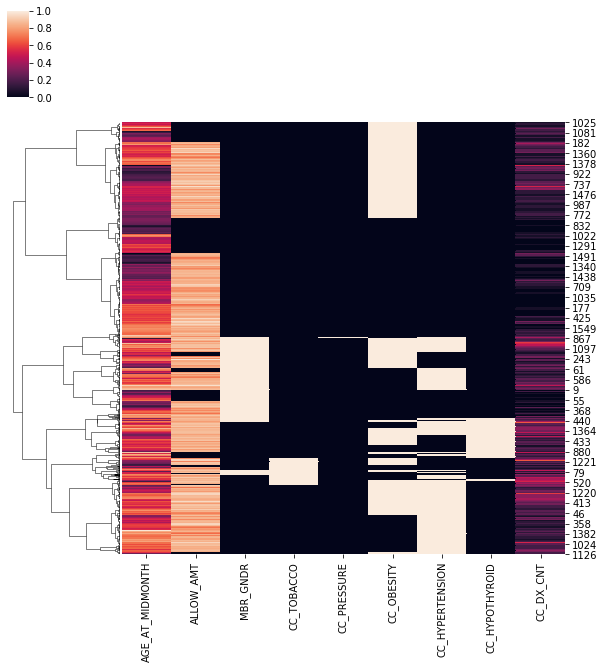

In [12]:
sns.clustermap(clustermapdat, method = 'ward', standard_scale=1, row_linkage = link_matr, col_cluster = False)

#### For each of the two clusters formed from the Treated patients form a matched population from the controls.
<div style="background:Aliceblue"> We use propensity score matching as our matching function</div>

In [13]:
%%time

columns_to_match = columns_to_match + ['AVG_IP', 'AVG_ER']

propensity_func_args = {'match_on':columns_to_match, 'neighbors_per_treated': 20}
matched0, matched_data0 = matched_population(treated0.copy(), 
                                           controls.copy(),
                                           propensity_func, 
                                           propensity_func_args)

matched1, matched_data1 = matched_population(treated1.copy(), 
                                           controls.copy(),
                                           propensity_func, 
                                           propensity_func_args)

Mathcing Function: propensity_func
Propensity Score Matching...fitting model
Creating Matched Set...


806it [39:05,  2.91s/it]


Mathcing Function: propensity_func
Propensity Score Matching...fitting model
Creating Matched Set...


775it [37:33,  2.91s/it]


CPU times: user 1h 11min 9s, sys: 29min 34s, total: 1h 40min 43s
Wall time: 1h 22min 35s


####  In addition to the previously created matched groups create a random group

In [14]:
random_matching_func_args = {'neighbors_per_treated': 100}
random_controls = matched_population(treated2.copy(), 
                                       controls.copy(),
                                       random_matching_func, 
                                       random_matching_func_args)

Mathcing Function: random_matching_func


In [15]:
Path('./temp2').mkdir(exist_ok = True)
p = './temp2/'
matched_data0.to_pickle(p+'match0.p')
matched_data1.to_pickle(p+'match1.p')
random_controls.to_pickle(p+'random.p')
treated0.to_pickle(p+'treated0.p')
treated1.to_pickle(p+'treated1.p')

#### Calculate the Diabetes onset for each of the created groups
1. Group 0: Group of treated patients cluster 0
2. Group 1: Group of treated patients Cluster 1
3. Group 2: Group of matched control patients to Group 0
4. Group 3: Group of matched control patients to Group 1
5. Group 4: Random Group

In [16]:
%%time
con_onset0 = diabet_onset(matched_data0.copy(), 'Diabetes_Con0')
con_onset1 = diabet_onset(matched_data1.copy(), 'Diabetes_Con1')

treated_onset0 = diabet_onset(treated0.copy(), 'Diabetes_Tr')
treated_onset1 = diabet_onset(treated1.copy(), 'Diabetes_Tr')

pmpm2 = filter_first_month_diabetes(pmpm.copy())
pmpm_onset = diabet_onset(pmpm2, 'Diabetes_PM')

CPU times: user 4min 6s, sys: 9.62 s, total: 4min 16s
Wall time: 4min 13s


In [17]:
random_onset = diabet_onset(random_controls.copy(), 'Diabetes_Rnd')

In [18]:
con_onset20 = con_onset0.rename(columns = {'Sample': 'Sample_Con0', 'Per_1000':'Per_1000_Con0'})
con_onset21 = con_onset1.rename(columns = {'Sample': 'Sample_Con1', 'Per_1000':'Per_1000_Con1'})

treated_onset20 = treated_onset0.rename(columns = {'Sample': 'Sample_Tr0', 'Per_1000':'Per_1000_Tr0'})
treated_onset21 = treated_onset1.rename(columns = {'Sample': 'Sample_Tr1', 'Per_1000':'Per_1000_Tr1'})

pmpm_onset2 = pmpm_onset.rename(columns = {'Sample': 'Sample_PM', 'Per_1000':'Per_1000_PM'})

In [19]:
random_onset2 = random_onset.rename(columns = {'Sample': 'Sample_PM', 'Per_1000':'Per_1000_PM'})
joint = pd.concat((con_onset20, con_onset21, treated_onset20, treated_onset21,  pmpm_onset2, random_onset2), axis = 1)

### Diabetes Onset Per Month Statistics

1. **_Con{i} : For Matched Controls Population**
2.  **_Tr{i} : For Canary Treated Population**
3. **_PM : For the whole PMPM Population**
4. **_Rnd: For a Random Matching**

>Sample_: The number of patients per month  
Diabetes_: The number of patients with Diabetes Onset in a month  
Per_1000_: The number of patients with Diabetes Onset in a a month per 1000  


In [20]:
joint.describe().loc[['mean', 'std']]

Sample_Con0  Diabetes_Con0  Per_1000_Con0  Sample_Con1  Diabetes_Con1  Per_1000_Con1  Sample_Tr0  Diabetes_Tr  Per_1000_Tr0  Sample_Tr1  Diabetes_Tr  Per_1000_Tr1      Sample_PM  Diabetes_PM  Per_1000_PM     Sample_PM  Diabetes_Rnd  Per_1000_PM
mean  4661.657895      10.342105       2.408311  3849.642857       6.666667       1.662393  266.947368     0.657895      1.945277  238.261905     0.404762      1.079355  143003.882353   279.901961     1.961085  32614.071429     58.095238     1.659479
std   3884.947788       8.987307       2.508940  3589.682538       6.997096       1.411793  227.590190     0.937977      4.333261  228.933163     0.700506      1.991768   13718.389511    44.775554     0.272818  28436.331025     51.143895     0.653605

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-dark')

In [22]:
joint2 = pd.concat((con_onset0, con_onset1, treated_onset0, treated_onset1,  pmpm_onset, random_onset), axis = 1)
jointcon0 = joint2.Per_1000.iloc[1:, 0].reset_index()
jointcon1 = joint2.Per_1000.iloc[1:, 1].reset_index()
jointTr0 = joint2.Per_1000.iloc[1:, 2].reset_index()

jointTr1 = joint2.Per_1000.iloc[1:, 3].reset_index()
jointpmpm = joint2.Per_1000.iloc[1:, 4].reset_index()
jointrandom = joint2.Per_1000.iloc[1:, 5].reset_index()


<div style="background:Aliceblue"> 
    <h3> Plot Top Left: $f(x)$ = Onset Per 1000 per month </h3>
    <h3> Plot Top Right and Bottom Left: $F(x) = \int_0^x f(y)dy$ <br>
        Cumulative sum of the rates </h3>
</div>

No handles with labels found to put in legend.


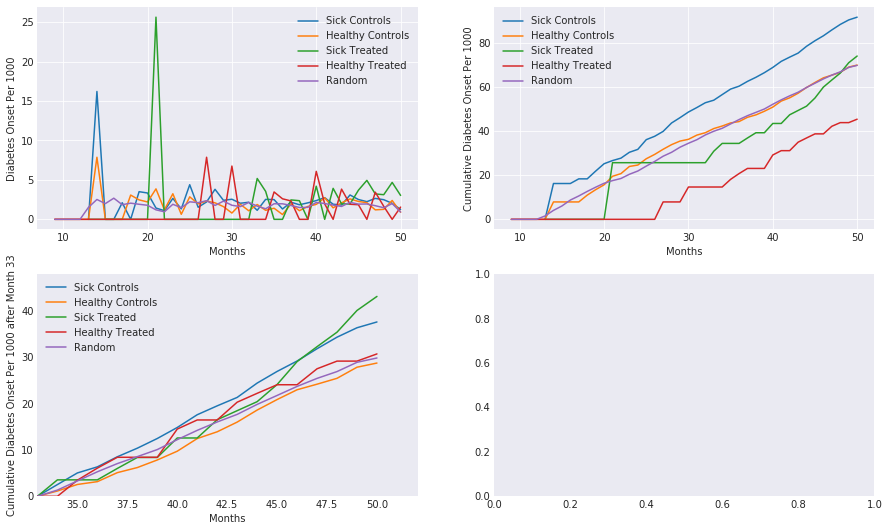

In [23]:
from diabetes_onset_plotter import plot_onset, plot_onset2
names = ['Sick Controls', 'Healthy Controls', 'Sick Treated', 'Healthy Treated', 'Random']
f, ax = plot_onset2(jointcon0, jointcon1, jointTr0, jointTr1, jointrandom, names = names)
plt.show()

In [24]:
def statistics_first_month(df, columns_to_match):
    df = df.sort_values(by = ['PERS_ID', 'MYR'])
    df = df.groupby('PERS_ID').apply(lambda x: pd.Series(x.iloc[0])).reset_index(drop = True)
    return df[columns_to_match].describe().loc[['mean']]#, df

In [25]:
try:
    pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    pass

In [26]:
%%time
tr_desc0 = statistics_first_month(treated0, columns_to_match)
tr_desc0 = tr_desc0.T

tr_desc1 = statistics_first_month(treated1, columns_to_match)
#tr_desc.index = pd.MultiIndex.from_product([['Treated'], tr_desc.index])
tr_desc1 = tr_desc1.T

con_desc0 = statistics_first_month(matched_data0, columns_to_match)
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc0 = con_desc0.T

con_desc1 = statistics_first_month(matched_data1, columns_to_match)
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc1 = con_desc1.T

pmpm_desc = statistics_first_month(pmpm2, columns_to_match)
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
pmpm_desc = pmpm_desc.T

random_desc = statistics_first_month(random_controls, columns_to_match)
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
random_desc = random_desc.T

CPU times: user 2min 56s, sys: 2.45 s, total: 2min 58s
Wall time: 2min 58s


In [27]:
alli = pd.concat((tr_desc0, tr_desc1, con_desc0, con_desc1, pmpm_desc, random_desc), axis = 1, keys = ['Sick Treated','Healthy Treated',
                                                                                                       'Sick Controls', 'Healthy Controls',
                                                                                                       'Genaral Population', 'Random'] )

## Statistics on matching date


In [28]:
alli

Sick Treated Healthy Treated Sick Controls Healthy Controls Genaral Population      Random
                        mean            mean          mean             mean               mean        mean
AGE_AT_MIDMONTH    53.677419       46.227097     52.743760        48.168808          43.048583   47.198098
ALLOW_AMT         803.847395      548.367742    795.414057       490.613318         986.578600  742.477410
MBR_GNDR            0.399504        0.000000      0.412366         0.000000           0.432864    0.425776
CC_TOBACCO          0.122829        0.000000      0.134749         0.040012           0.072285    0.096591
CC_PRESSURE         0.002481        0.000000      0.011229         0.003140           0.003787    0.006132
CC_OBESITY          0.449132        0.446452      0.293986         0.460061           0.092396    0.220357
CC_HYPERTENSION     0.631514        0.000000      0.584929         0.099810           0.174132    0.245557
CC_HYPOTHYROID      0.181141        0.000000      0.131976         0.052132           0.041370    0.062934
CC_DX_CNT           3.451613        1.775484      3.525266         1.872445           1.531662    2.301849
AVG_IP              0.007702        0.004007      0.013696         0.007127           0.021202    0.011467
AVG_ER              0.017886        0.012239      0.026758         0.016729           0.047478    0.025622

In [29]:
tr_desc0 = treated0[columns_to_match].describe().loc[['mean']]
#tr_desc.index = pd.MultiIndex.from_product([['Treated'], tr_desc.index])
tr_desc0 = tr_desc0.T

tr_desc1 = treated1[columns_to_match].describe().loc[['mean']]
#tr_desc.index = pd.MultiIndex.from_product([['Treated'], tr_desc.index])
tr_desc1 = tr_desc1.T

con_desc0 = matched_data0[columns_to_match].describe().loc[['mean']]
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc0 = con_desc0.T

con_desc1 = matched_data1[columns_to_match].describe().loc[['mean']]
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc1 = con_desc1.T

pmpm_desc = pmpm2[columns_to_match].describe().loc[['mean']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
pmpm_desc = pmpm_desc.T

random_desc = random_controls[columns_to_match].describe().loc[['mean']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
random_desc = random_desc.T

alli = pd.concat((tr_desc0, tr_desc1, con_desc0, con_desc1, pmpm_desc, random_desc), axis = 1, keys = ['Sick Treated','Healthy Treated',
                                                                                                       'Sick Controls', 'Healthy Controls',
                                                                                                       'Genaral Population', 'Random'] )

#### Univariate Means of the Groups under Study of interesting features
>The "Sick groups" have:  
a) Older age  
b) More Expenditures  
c) Smoke More  
d) Have More People with Hypertension


In [30]:
alli

Sick Treated Healthy Treated Sick Controls Healthy Controls Genaral Population      Random
                        mean            mean          mean             mean               mean        mean
AGE_AT_MIDMONTH    54.023395       46.806244     54.403924        49.414419          48.759167   49.865170
ALLOW_AMT         898.552321      621.149369    843.011308       613.776117         748.531555  732.721378
MBR_GNDR            0.368154        0.000000      0.371339         0.000124           0.421103    0.420245
CC_TOBACCO          0.115705        0.014919      0.142392         0.052911           0.099304    0.104189
CC_PRESSURE         0.004353        0.000000      0.011714         0.004540           0.007168    0.007362
CC_OBESITY          0.472252        0.516162      0.335018         0.488889           0.231656    0.275713
CC_HYPERTENSION     0.565470        0.069251      0.550130         0.159414           0.283097    0.292760
CC_HYPOTHYROID      0.160591        0.026982      0.136129         0.074650           0.069572    0.073965
CC_DX_CNT           3.458288        2.153237      3.732308         2.286430           2.539357    2.719678
AVG_IP              0.006969        0.004042      0.012447         0.006950           0.011847    0.010275
AVG_ER              0.018144        0.012515      0.025303         0.016735           0.025423    0.022600

#### Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

In [31]:
def plot0():
    fig, ax = plt.subplots(3,3, figsize = (15,9))
    for i in range(3):
        for j in range(3):
            column = columns_to_match[i*3 + j]
            if column == 'ALLOW_AMT':
                treated00 = treated0.copy()
                treated00[column] = np.log(treated00[column].values + 10**(-10))
                matched00 = matched_data0.copy()
                matched00[column] = np.log(matched00[column].values + 10**(-10))

                sns.distplot(treated00[column], ax = ax[i,j])
                sns.distplot(matched00[column], ax = ax[i,j])
                ax[i,j].legend(['S Treated', 'S Controls'])
            else:
                sns.distplot(treated0[column], ax = ax[i,j])
                sns.distplot(matched_data0[column], ax = ax[i, j])
                ax[i,j].legend(['S Treated', 'S Controls'])

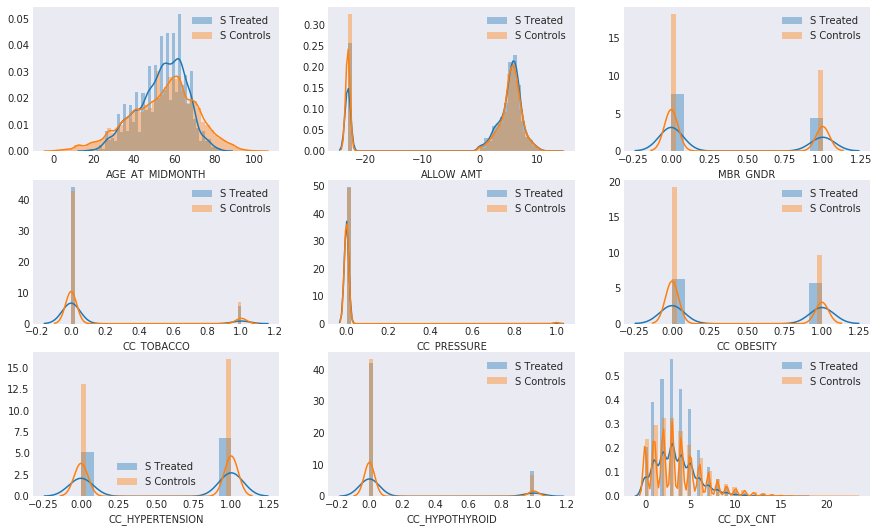

In [32]:
plot0()

In [33]:
def plot1():
    fig, ax = plt.subplots(3,3, figsize = (15,9))
    for i in range(3):
        for j in range(3):
            column = columns_to_match[i*3 + j]

            try:
                if column == 'ALLOW_AMT':
                    treated00 = treated1.copy()
                    treated00[column] = np.log(treated00[column].values + 10**(-10))
                    matched00 = matched_data1.copy()
                    matched00[column] = np.log(matched00[column].values + 10**(-10))

                    sns.distplot(treated00[column], ax = ax[i,j])
                    sns.distplot(matched00[column], ax = ax[i,j])
                    ax[i,j].legend(['H Treated', 'H Controls'])
                else:
                    sns.distplot(treated1[column], ax = ax[i,j])
                    sns.distplot(matched_data1[column], ax = ax[i, j])
                    ax[i,j].legend(['H Treated', 'H Controls'])
                    ax.set_title('Bla')
            except:
                continue

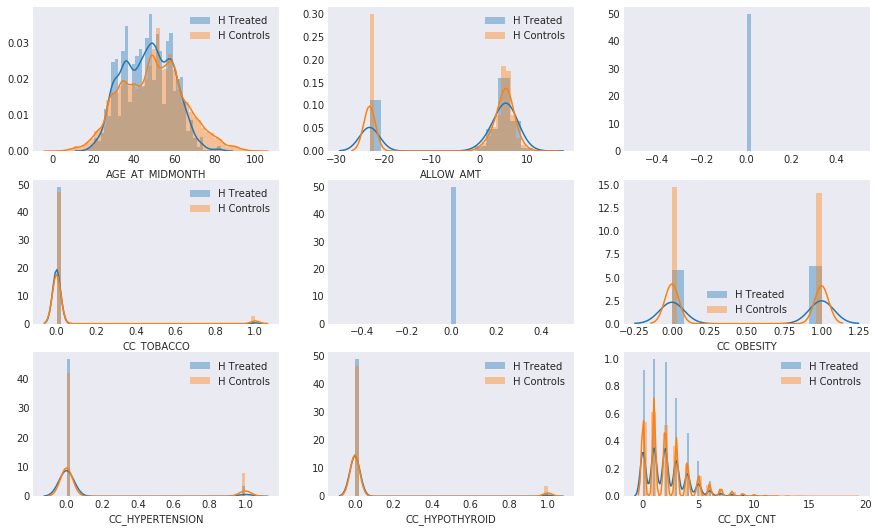

In [34]:
plot1()